# Knowledge Distillation for Reverse Dictionary

## Concept: Train a Text-Only Student to Mimic a Multimodal Teacher

This notebook implements **knowledge distillation** for the Reverse Dictionary task:

1. **Teacher Model** (frozen): Multimodal model that takes (definition + image) → produces embedding vector
2. **Student Model** (trainable): Text-only model that takes (definition) → produces embedding vector
3. **Distillation Loss**: Minimize distance between student and teacher outputs

### The Distillation Loop:
- Pass (definition, image) to frozen Teacher → Get Teacher_Vector
- Pass (definition) to Student → Get Student_Vector  
- Loss: MSE(Student_Vector, Teacher_Vector)

### Result:
The student learns to produce the same embeddings as the teacher, effectively incorporating the teacher's multimodal understanding into a text-only model. At inference time, the student doesn't need images!

### Key Advantage:
The student can now leverage both text AND implicit image information (learned from teacher), achieving better performance than a naive text-only model trained on ground-truth GloVe vectors.


In [1]:
# Environment check and imports
try:
    import torch, numpy as np
    import transformers
    print('Found: torch, numpy, transformers')
except Exception as e:
    print('Missing packages. Install with:')
    print('  python3 -m pip install numpy torch transformers tqdm scikit-learn')
    raise

# Imports from project
from teacher import TeacherModel, TeacherDataset, collate_examples, load_glove_embeddings
from student import StudentModel, TextOnlyDataset, train_one_epoch, evaluate

from pathlib import Path
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
import random

print('Imports OK')


/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found: torch, numpy, transformers
Imports OK
Imports OK


In [2]:
# Configuration
DATASET = 'dataset.json'
GLOVE = './glove.6B.300d.txt'
BERT = 'bert-base-uncased'
TEACHER_MODEL_PATH = './ckpts/teacher_model.pt'
STUDENT_MODEL_INIT = './ckpts/student_model.pt'  # Can optionally initialize from existing student

BATCH = 16
EPOCHS = 15
LR = 2e-5
MAXLEN = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
VAL_SPLIT = 0.1
ALPHA = 0.9  # Weight for teacher loss (0.5 = 50% teacher + 50% glove ground truth)

print('Device:', DEVICE)
print(f'Config: EPOCHS={EPOCHS}, BATCH={BATCH}, LR={LR}, ALPHA={ALPHA}')
print(f'Hybrid Loss: {ALPHA:.1%} teacher + {1.0-ALPHA:.1%} glove ground truth')


Device: mps
Config: EPOCHS=15, BATCH=16, LR=2e-05, ALPHA=0.9
Hybrid Loss: 90.0% teacher + 10.0% glove ground truth


In [3]:
# Load GloVe and datasets
print('Loading GloVe...')
glove = load_glove_embeddings(GLOVE)
embedding_dim = next(iter(glove.values())).shape[0]
print(f'GloVe dimension: {embedding_dim}')

print('Loading datasets...')
# TeacherDataset includes both text and image
teacher_ds = TeacherDataset(DATASET, glove, tokenizer_name=BERT, max_length=MAXLEN)
print(f'Dataset size: {len(teacher_ds)}')

# Train/val split (random shuffle)
n = len(teacher_ds)
val_n = int(VAL_SPLIT * n)
train_n = n - val_n

indices = list(range(n))
random.shuffle(indices)
train_idx = indices[:train_n]
val_idx = indices[train_n:]

train_ds = Subset(teacher_ds, train_idx)
val_ds = Subset(teacher_ds, val_idx)

print(f'Train size: {len(train_ds)}, Val size: {len(val_ds)}')


Loading GloVe...
GloVe dimension: 300
Loading datasets...
GloVe dimension: 300
Loading datasets...
Dataset size: 971
Train size: 874, Val size: 97
Dataset size: 971
Train size: 874, Val size: 97


## Section 1: Data Loading & Model Preparation

Above we:
- Loaded both TeacherDataset (with images) and created train/val splits
- Loaded the frozen TeacherModel (multimodal: BERT + ResNet-50)
- Initialized the StudentModel (text-only: BERT only)
- Froze all teacher parameters to prevent updates


In [4]:
# Load Teacher Model (frozen)
print('Loading Teacher Model...')
teacher = TeacherModel(bert_model_name=BERT, target_dim=embedding_dim)

if Path(TEACHER_MODEL_PATH).exists():
    try:
        teacher.load_state_dict(torch.load(TEACHER_MODEL_PATH, map_location=DEVICE))
        print(f'Loaded teacher from {TEACHER_MODEL_PATH}')
    except Exception as e:
        print(f'Warning: Could not load teacher: {e}')
else:
    print(f'Warning: Teacher model not found at {TEACHER_MODEL_PATH}, using random init')

teacher.to(DEVICE)
teacher.eval()  # Evaluation mode
for param in teacher.parameters():
    param.requires_grad = False  # Freeze all parameters

print('Teacher model frozen (no gradients)')

# Initialize Student Model (trainable)
print('\nInitializing Student Model...')
student = StudentModel(bert_model_name=BERT, target_dim=embedding_dim)

# Optionally load from pre-trained student (e.g., from student_test.ipynb training)
if Path(STUDENT_MODEL_INIT).exists():
    try:
        student.load_state_dict(torch.load(STUDENT_MODEL_INIT, map_location=DEVICE))
        print(f'Initialized student from {STUDENT_MODEL_INIT}')
    except Exception as e:
        print(f'Note: Could not load student init: {e}, using random init')
else:
    print(f'Student initialized with random weights')

student.to(DEVICE)
student.train()  # Training mode

print(f'\nTeacher params: {sum(p.numel() for p in teacher.parameters())}')
print(f'Student params: {sum(p.numel() for p in student.parameters())}')
print(f'Student trainable params: {sum(p.numel() for p in student.parameters() if p.requires_grad)}')


Loading Teacher Model...


/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/catherineli/UMD/CMSC498K/Final Project/ReverseDictionary/.venv/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded teacher from ./ckpts/teacher_model.pt
Teacher model frozen (no gradients)

Initializing Student Model...
Initialized student from ./ckpts/student_model.pt

Teacher params: 133835372
Student params: 109712940
Student trainable params: 109712940
Initialized student from ./ckpts/student_model.pt

Teacher params: 133835372
Student params: 109712940
Student trainable params: 109712940


In [5]:
# Setup optimizer and loss function
optimizer = torch.optim.AdamW([p for p in student.parameters() if p.requires_grad], lr=LR)
criterion = torch.nn.MSELoss()

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, collate_fn=lambda x: collate_examples(x))
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, collate_fn=lambda x: collate_examples(x))

print(f'Optimizer: AdamW (lr={LR})')
print(f'Loss: MSELoss (between student and teacher vectors)')
print(f'Train loader: {len(train_loader)} batches')
print(f'Val loader: {len(val_loader)} batches')


Optimizer: AdamW (lr=2e-05)
Loss: MSELoss (between student and teacher vectors)
Train loader: 55 batches
Val loader: 7 batches


## Section 2: Distillation Training Loop

The key insight of distillation:
- **Teacher sees**: (definition tokens, image) → produces embedding
- **Student sees**: (definition tokens only) → produces embedding
- **Loss**: MSE between student output and teacher output

This teaches the student to produce teacher-like embeddings from text alone.


In [6]:
losses_train = []
losses_val_hybrid = []
losses_val_teacher = []
losses_val_glove = []
best_val_mse = float('inf')

print(f'Starting distillation training for {EPOCHS} epochs (alpha={ALPHA})...\n')

for epoch in range(1, EPOCHS + 1):
    # === TRAINING ===
    student.train()
    teacher.eval()  # Always eval for teacher
    
    total_train_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} [train]', leave=False)
    for batch in pbar:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        image = batch['image'].to(DEVICE)
        gt_vector = batch['vector'].to(DEVICE)
        
        # Forward through frozen teacher (multimodal)
        with torch.no_grad():
            teacher_output = teacher(
                input_ids=input_ids,
                attention_mask=attention_mask,
                image=image,
                training=False
            )
        
        # Forward through student (text-only)
        student_output = student(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Hybrid distillation loss
        # Loss = alpha * MSE(student, teacher) + (1-alpha) * MSE(student, glove)
        teacher_loss = criterion(student_output, teacher_output.detach())
        glove_loss = criterion(student_output, gt_vector)
        loss = ALPHA * teacher_loss + (1.0 - ALPHA) * glove_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        num_batches += 1
        pbar.set_postfix({'loss': f"{loss.item():.6f}"})
    
    avg_train_loss = total_train_loss / max(num_batches, 1)
    losses_train.append(avg_train_loss)
    
    # === VALIDATION ===
    student.eval()
    total_val_hybrid_loss = 0.0
    total_val_teacher_loss = 0.0
    total_val_glove_loss = 0.0
    total_cosine_sim = 0.0
    num_val_batches = 0
    
    pbar = tqdm(val_loader, desc=f'Epoch {epoch} [val]', leave=False)
    for batch in pbar:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        image = batch['image'].to(DEVICE)
        gt_vector = batch['vector'].to(DEVICE)
        
        with torch.no_grad():
            teacher_output = teacher(
                input_ids=input_ids,
                attention_mask=attention_mask,
                image=image,
                training=False
            )
            student_output = student(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Compute both MSE components
            teacher_mse = criterion(student_output, teacher_output)
            glove_mse = criterion(student_output, gt_vector)
            hybrid_mse = ALPHA * teacher_mse + (1.0 - ALPHA) * glove_mse
            
            total_val_hybrid_loss += hybrid_mse.item()
            total_val_teacher_loss += teacher_mse.item()
            total_val_glove_loss += glove_mse.item()
            
            # Cosine similarity (batch-wise average)
            student_np = student_output.cpu().numpy()
            teacher_np = teacher_output.cpu().numpy()
            batch_cosine = np.mean([
                np.dot(student_np[i], teacher_np[i]) / 
                (np.linalg.norm(student_np[i]) * np.linalg.norm(teacher_np[i]) + 1e-8)
                for i in range(len(student_np))
            ])
            total_cosine_sim += batch_cosine
            
            num_val_batches += 1
    
    avg_val_hybrid_loss = total_val_hybrid_loss / max(num_val_batches, 1)
    avg_val_teacher_loss = total_val_teacher_loss / max(num_val_batches, 1)
    avg_val_glove_loss = total_val_glove_loss / max(num_val_batches, 1)
    avg_cosine_sim = total_cosine_sim / max(num_val_batches, 1)
    
    losses_val_hybrid.append(avg_val_hybrid_loss)
    losses_val_teacher.append(avg_val_teacher_loss)
    losses_val_glove.append(avg_val_glove_loss)
    
    print(f'Epoch {epoch}: train_loss={avg_train_loss:.6f} val_hybrid={avg_val_hybrid_loss:.6f} val_teacher={avg_val_teacher_loss:.6f} val_glove={avg_val_glove_loss:.6f} cosine={avg_cosine_sim:.6f}')
    
    # Save best model based on hybrid loss
    if avg_val_hybrid_loss < best_val_mse:
        best_val_mse = avg_val_hybrid_loss
        model_path = Path('./ckpts/student_distilled.pt')
        model_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(student.state_dict(), model_path)
        print(f'  -> Saved best model to {model_path}')

print(f'\nDistillation training complete!')
print(f'Best val hybrid MSE: {best_val_mse:.6f}')


Starting distillation training for 15 epochs (alpha=0.9)...



Epoch 1: train_loss=0.020054 val_hybrid=0.019639 val_teacher=0.009476 val_glove=0.111107 cosine=0.793629
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 2: train_loss=0.018252 val_hybrid=0.019222 val_teacher=0.009079 val_glove=0.110507 cosine=0.803129
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 3: train_loss=0.017756 val_hybrid=0.018834 val_teacher=0.008682 val_glove=0.110197 cosine=0.813944
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 4: train_loss=0.017271 val_hybrid=0.018562 val_teacher=0.008419 val_glove=0.109849 cosine=0.820706
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 5: train_loss=0.016965 val_hybrid=0.018474 val_teacher=0.008310 val_glove=0.109954 cosine=0.823013
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 6: train_loss=0.016690 val_hybrid=0.018393 val_teacher=0.008255 val_glove=0.109630 cosine=0.823768
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 7: train_loss=0.016489 val_hybrid=0.018308 val_teacher=0.008135 val_glove=0.109860 cosine=0.829002
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 8: train_loss=0.016298 val_hybrid=0.018199 val_teacher=0.008057 val_glove=0.109480 cosine=0.830180
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 9: train_loss=0.016162 val_hybrid=0.018222 val_teacher=0.008089 val_glove=0.109426 cosine=0.829030


Epoch 10: train_loss=0.015976 val_hybrid=0.018234 val_teacher=0.008077 val_glove=0.109645 cosine=0.832140


Epoch 11: train_loss=0.015832 val_hybrid=0.018121 val_teacher=0.007971 val_glove=0.109469 cosine=0.832759
  -> Saved best model to ckpts/student_distilled.pt
  -> Saved best model to ckpts/student_distilled.pt


Epoch 12: train_loss=0.015654 val_hybrid=0.018154 val_teacher=0.008038 val_glove=0.109207 cosine=0.830875


Epoch 13: train_loss=0.015578 val_hybrid=0.018202 val_teacher=0.008109 val_glove=0.109039 cosine=0.831188


Epoch 14: train_loss=0.015399 val_hybrid=0.018148 val_teacher=0.007987 val_glove=0.109594 cosine=0.832499


Epoch 15: train_loss=0.015275 val_hybrid=0.018159 val_teacher=0.008066 val_glove=0.108994 cosine=0.832488

Distillation training complete!
Best val hybrid MSE: 0.018121


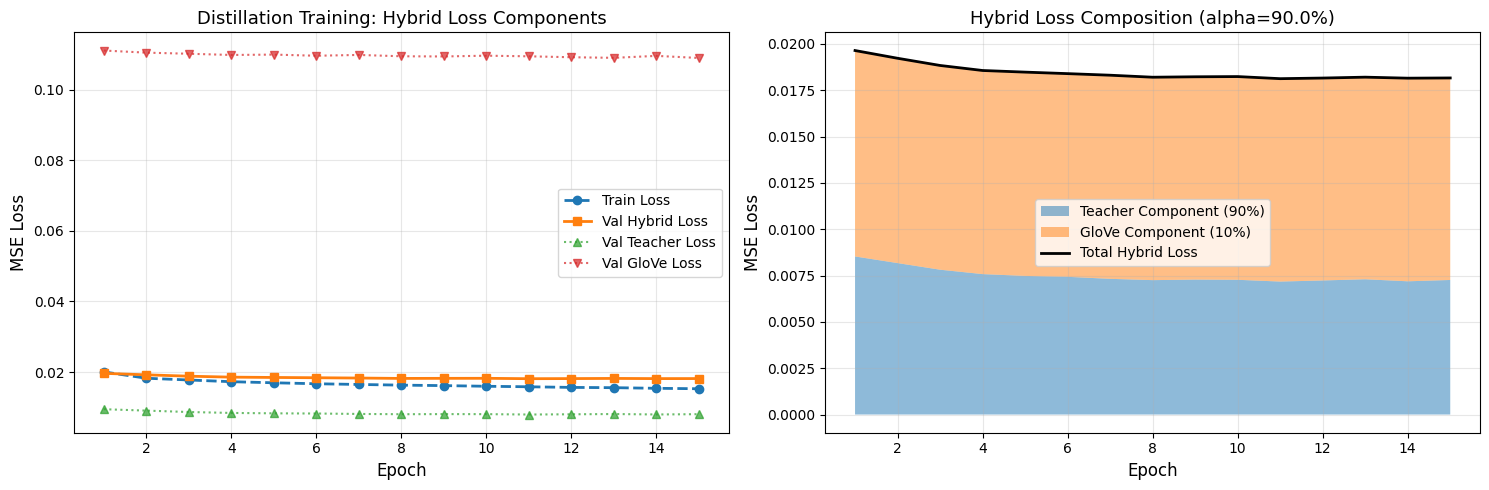

Training Summary:
  Train Loss: 0.015275 -> 0.015275
  Val Hybrid: 0.019639 -> 0.018121
  Val Teacher: 0.009476 -> 0.007971
  Val GloVe: 0.111107 -> 0.108994


In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: Hybrid loss vs components
axes[0].plot(range(1, EPOCHS + 1), losses_train, label='Train Loss', marker='o', linestyle='--', linewidth=2)
axes[0].plot(range(1, EPOCHS + 1), losses_val_hybrid, label='Val Hybrid Loss', marker='s', linestyle='-', linewidth=2)
axes[0].plot(range(1, EPOCHS + 1), losses_val_teacher, label='Val Teacher Loss', marker='^', linestyle=':', linewidth=1.5, alpha=0.7)
axes[0].plot(range(1, EPOCHS + 1), losses_val_glove, label='Val GloVe Loss', marker='v', linestyle=':', linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Distillation Training: Hybrid Loss Components', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: Component contribution
axes[1].fill_between(range(1, EPOCHS + 1), 0, [t*ALPHA for t in losses_val_teacher], alpha=0.5, label=f'Teacher Component ({ALPHA:.0%})')
axes[1].fill_between(range(1, EPOCHS + 1), [t*ALPHA for t in losses_val_teacher], losses_val_hybrid, alpha=0.5, label=f'GloVe Component ({1.0-ALPHA:.0%})')
axes[1].plot(range(1, EPOCHS + 1), losses_val_hybrid, color='black', linestyle='-', linewidth=2, label='Total Hybrid Loss')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MSE Loss', fontsize=12)
axes[1].set_title('Hybrid Loss Composition (alpha={:.1%})'.format(ALPHA), fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Training Summary:')
print(f'  Train Loss: {min(losses_train):.6f} -> {losses_train[-1]:.6f}')
print(f'  Val Hybrid: {max(losses_val_hybrid):.6f} -> {min(losses_val_hybrid):.6f}')
print(f'  Val Teacher: {max(losses_val_teacher):.6f} -> {min(losses_val_teacher):.6f}')
print(f'  Val GloVe: {max(losses_val_glove):.6f} -> {min(losses_val_glove):.6f}')


## Section 3: Evaluate Student vs Teacher Alignment

Now we evaluate the trained student model:
1. Compute alignment metrics (MSE, cosine similarity) on validation set
2. Compare student embeddings to teacher embeddings
3. Visualize the vector space using t-SNE


In [8]:
# Load best distilled student model
best_student_path = Path('./ckpts/student_distilled.pt')
if best_student_path.exists():
    student.load_state_dict(torch.load(best_student_path, map_location=DEVICE))
    print(f'Loaded best distilled student from {best_student_path}')
else:
    print('Using current student model')

# Evaluate on full validation set
student.eval()
teacher.eval()

all_student_vecs = []
all_teacher_vecs = []
all_words = []
all_defs = []

print('Collecting student and teacher vectors on validation set...')
for batch in tqdm(val_loader, desc='Collecting embeddings', leave=False):
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    image = batch['image'].to(DEVICE)
    
    with torch.no_grad():
        teacher_out = teacher(input_ids=input_ids, attention_mask=attention_mask, image=image, training=False)
        student_out = student(input_ids=input_ids, attention_mask=attention_mask)
    
    all_student_vecs.append(student_out.cpu().numpy())
    all_teacher_vecs.append(teacher_out.cpu().numpy())
    all_words.extend(batch.get('word', batch.get('words', [])))
    all_defs.extend(batch.get('def', batch.get('definition', [])))

student_vecs = np.vstack(all_student_vecs)
teacher_vecs = np.vstack(all_teacher_vecs)

print(f'Collected {len(student_vecs)} embeddings')
print(f'Student shape: {student_vecs.shape}')
print(f'Teacher shape: {teacher_vecs.shape}')

# Compute alignment metrics
mse_alignment = np.mean((student_vecs - teacher_vecs) ** 2)
cosine_sims = [
    np.dot(student_vecs[i], teacher_vecs[i]) / 
    (np.linalg.norm(student_vecs[i]) * np.linalg.norm(teacher_vecs[i]) + 1e-8)
    for i in range(len(student_vecs))
]
mean_cosine = np.mean(cosine_sims)
median_cosine = np.median(cosine_sims)

print(f'\n=== Student-Teacher Alignment ===')
print(f'MSE: {mse_alignment:.6f}')
print(f'Mean Cosine Similarity: {mean_cosine:.6f}')
print(f'Median Cosine Similarity: {median_cosine:.6f}')
print(f'Cosine Similarity range: [{min(cosine_sims):.4f}, {max(cosine_sims):.4f}]')


Loaded best distilled student from ckpts/student_distilled.pt


Collected 97 embeddings
Student shape: (97, 300)
Teacher shape: (97, 300)

=== Student-Teacher Alignment ===
MSE: 0.007983
Mean Cosine Similarity: 0.833155
Median Cosine Similarity: 0.844811
Cosine Similarity range: [0.6577, 0.9294]


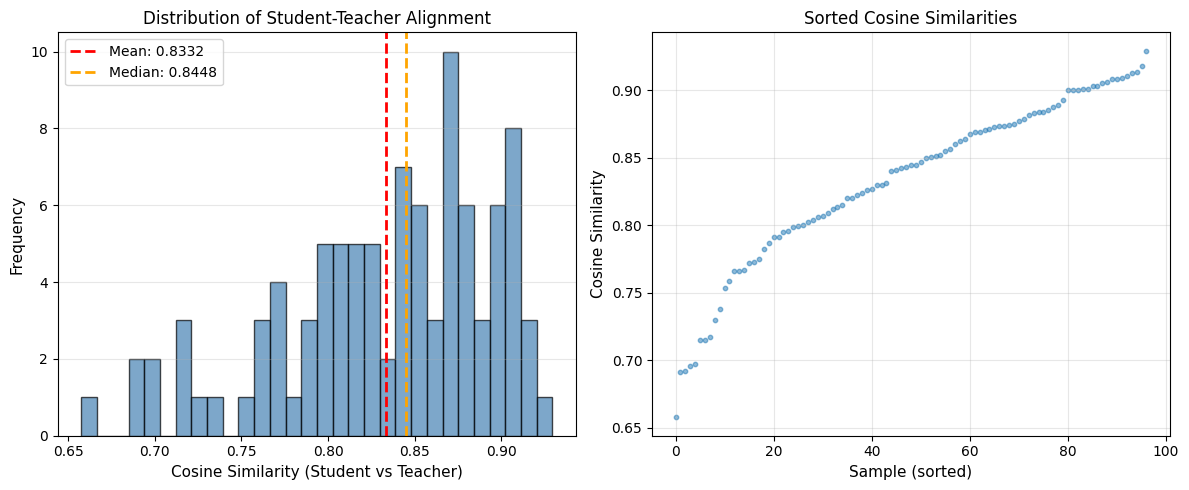

In [9]:
# Visualize cosine similarity distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(cosine_sims, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Cosine Similarity (Student vs Teacher)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Student-Teacher Alignment', fontsize=12)
plt.axvline(mean_cosine, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_cosine:.4f}')
plt.axvline(median_cosine, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_cosine:.4f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(range(len(cosine_sims)), sorted(cosine_sims), alpha=0.5, s=10)
plt.xlabel('Sample (sorted)', fontsize=11)
plt.ylabel('Cosine Similarity', fontsize=11)
plt.title('Sorted Cosine Similarities', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Section 4: Vector Space Visualization (t-SNE)

Visualize how well the student's vector space aligns with the teacher's vector space using t-SNE.


Applying t-SNE to student and teacher vectors...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Student 2D: (97, 2)
Teacher 2D: (97, 2)


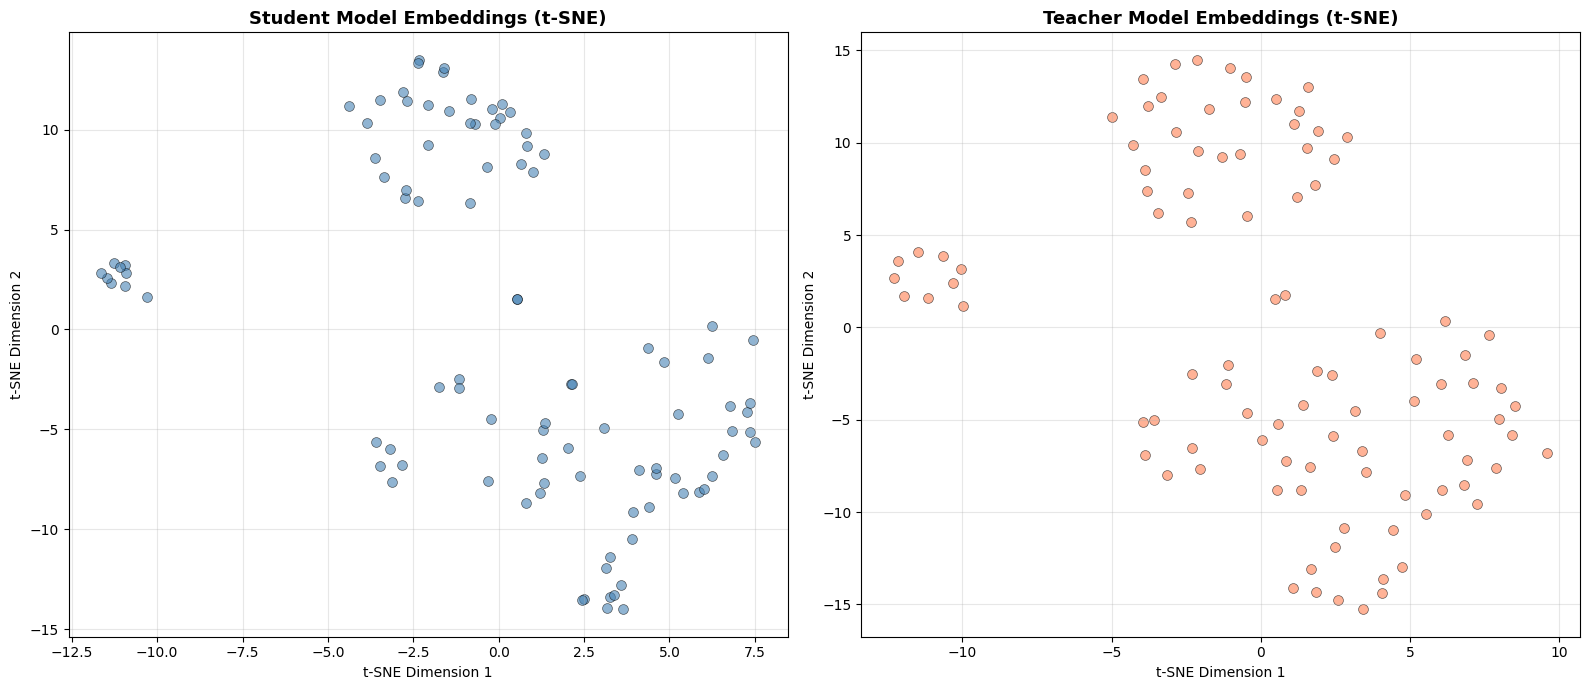

Visualization complete!


In [10]:
# Reduce to 2D for visualization
from sklearn.manifold import TSNE

print('Applying t-SNE to student and teacher vectors...')

# Combine for consistent fit
combined = np.vstack([student_vecs, teacher_vecs])
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
combined_2d = tsne.fit_transform(combined)

student_2d = combined_2d[:len(student_vecs)]
teacher_2d = combined_2d[len(student_vecs):]

print(f'Student 2D: {student_2d.shape}')
print(f'Teacher 2D: {teacher_2d.shape}')

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Student embeddings
axes[0].scatter(student_2d[:, 0], student_2d[:, 1], alpha=0.6, s=50, c='steelblue', edgecolors='k', linewidth=0.5)
axes[0].set_title('Student Model Embeddings (t-SNE)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].grid(True, alpha=0.3)

# Teacher embeddings (using same t-SNE fit)
axes[1].scatter(teacher_2d[:, 0], teacher_2d[:, 1], alpha=0.6, s=50, c='coral', edgecolors='k', linewidth=0.5)
axes[1].set_title('Teacher Model Embeddings (t-SNE)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Visualization complete!')


## Section 5: Compare Distilled Student vs Vanilla Baseline

Now let's compare the distilled student to a vanilla text-only baseline (trained on ground-truth GloVe):
- **Vanilla Student**: Trained to match GloVe targets
- **Distilled Student**: Trained to match teacher targets

The distilled student should achieve better retrieval and alignment metrics.


In [11]:
from student import collate_examples

In [12]:
# Create vanilla text-only dataset (for comparison)
print('Creating vanilla text-only dataset for comparison...')
vanilla_ds = TextOnlyDataset(DATASET, glove, tokenizer_name=BERT, max_length=MAXLEN)

# Use same split indices
vanilla_val_ds = Subset(vanilla_ds, val_idx)
vanilla_val_loader = DataLoader(vanilla_val_ds, batch_size=BATCH, shuffle=False, collate_fn=lambda x: collate_examples(x))

# Load vanilla student model (from student_test.ipynb training)
vanilla_student_path = Path('./ckpts/student_model.pt')
vanilla_student = StudentModel(bert_model_name=BERT, target_dim=embedding_dim)

if vanilla_student_path.exists():
    try:
        vanilla_student.load_state_dict(torch.load(vanilla_student_path, map_location=DEVICE))
        print(f'Loaded vanilla student from {vanilla_student_path}')
    except Exception as e:
        print(f'Could not load vanilla student: {e}')
        print('Will use random init (comparison may not be meaningful)')

vanilla_student.to(DEVICE)
vanilla_student.eval()

print('Vanilla student ready')


Creating vanilla text-only dataset for comparison...
Loaded vanilla student from ckpts/student_model.pt
Vanilla student ready
Loaded vanilla student from ckpts/student_model.pt
Vanilla student ready


In [24]:
# Retrieval utilities: use dataset (TextOnlyDataset or TeacherDataset) as candidate DB
from transformers import AutoTokenizer
from collections import defaultdict

def build_db_from_dataset(dataset, glove_dict):
    """Construct candidate DB (words, definitions, glove vectors) from a dataset.
    Returns (db_words, db_defs, db_vecs)
    Only includes words present in glove_dict.
    """
    db_words = []
    db_defs = []
    seen = set()
    for i in range(len(dataset)):
        item = dataset[i]
        # dataset item may provide 'word' and 'definition' keys
        word = item.get('word', item.get('words', None))
        definition = item.get('definition', item.get('def', ''))
        if word is None:
            continue
        if word in seen:
            continue
        if word not in glove_dict:
            continue
        db_words.append(word)
        db_defs.append(definition)
        seen.add(word)

    if len(db_words) == 0:
        return [], [], np.zeros((0, next(iter(glove_dict.values())).shape[0]))

    db_vecs = np.stack([glove_dict[w] for w in db_words])
    return db_words, db_defs, db_vecs

# tokenizer for one-shot queries
tokenizer = AutoTokenizer.from_pretrained(BERT)

def retrieve_topK(definition: str, model, db_words, db_defs, db_vecs, k=10, device=DEVICE):
    """Given a definition string and a model, return top-k (word, def, similarity).
    db_vecs should correspond to glove vectors for db_words.
    Similarity is cosine between model embedding and db_vecs.
    """
    model.eval()
    inputs = tokenizer(definition, return_tensors='pt', truncation=True, padding='max_length', max_length=MAXLEN)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        qvec = model(input_ids=input_ids, attention_mask=attention_mask)
    q = qvec.cpu().numpy().reshape(-1)

    if db_vecs.shape[0] == 0:
        return []

    db_norms = np.linalg.norm(db_vecs, axis=1)
    db_norms[db_norms == 0] = 1.0
    q_norm = np.linalg.norm(q) if np.linalg.norm(q) != 0 else 1.0
    sims = (db_vecs @ q) / (db_norms * q_norm)
    idxs = np.argsort(-sims)[:k]
    results = [(db_words[i], db_defs[i], float(sims[i])) for i in idxs]
    return results


def evaluate_retrieval(model, db_words, db_defs, db_vecs, query_loader, k_values=[1,5,10,20], teacher_model=None):
    """Evaluate retrieval metrics for queries from query_loader against the provided DB.
    If teacher_model is provided, also compute student-teacher MSE and average cosine.
    Returns dict with recalls, ranks list, avg_mse (or np.nan), avg_cosine (or np.nan).
    """
    model.eval()
    if teacher_model is not None:
        teacher_model.eval()

    total_considered = 0
    correct = defaultdict(int)
    ranks = []
    mse_sum = 0.0
    cosine_sum = 0.0
    num_pairs = 0

    # Pre-normalize db_vecs for speed
    if db_vecs.shape[0] > 0:
        db_norms = np.linalg.norm(db_vecs, axis=1)
        db_norms[db_norms == 0] = 1.0
    else:
        db_norms = np.array([])

    for batch in tqdm(query_loader, desc='Evaluating retrieval', leave=False):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        with torch.no_grad():
            svecs = model(input_ids=input_ids, attention_mask=attention_mask)
            s_np = svecs.cpu().numpy()

            # If teacher available and batch provides images, compute teacher vectors for MSE/cosine
            if teacher_model is not None and 'image' in batch:
                image = batch['image'].to(DEVICE)
                tvecs = teacher_model(input_ids=input_ids, attention_mask=attention_mask, image=image, training=False)
                t_np = tvecs.cpu().numpy()
            else:
                t_np = None

        words = batch.get('word', batch.get('words', []))

        for i, word in enumerate(words):
            qvec = s_np[i]
            if db_vecs.shape[0] == 0:
                ranks.append(np.nan)
                continue

            sims = (db_vecs @ qvec) / (db_norms * (np.linalg.norm(qvec) if np.linalg.norm(qvec) != 0 else 1.0))
            retrieved_idxs = np.argsort(-sims)

            if word not in db_words:
                ranks.append(np.nan)
                continue

            total_considered += 1
            target_idx = db_words.index(word)
            rank_positions = np.where(retrieved_idxs == target_idx)[0]
            rank = int(rank_positions[0]) + 1 if len(rank_positions) > 0 else len(db_words) + 1
            ranks.append(rank)

            for k in k_values:
                if target_idx in retrieved_idxs[:k]:
                    correct[k] += 1

            # student-teacher metrics
            if t_np is not None:
                mse_sum += np.mean((qvec - t_np[i]) ** 2)
                cosine_sum += np.dot(qvec, t_np[i]) / ((np.linalg.norm(qvec) * np.linalg.norm(t_np[i])) + 1e-8)
                num_pairs += 1

    recalls = {k: (correct[k] / total_considered if total_considered > 0 else 0.0) for k in k_values}
    avg_mse = (mse_sum / num_pairs) if num_pairs > 0 else float('nan')
    avg_cosine = (cosine_sum / num_pairs) if num_pairs > 0 else float('nan')

    return { 'recalls': recalls, 'ranks': ranks, 'avg_mse': avg_mse, 'avg_cosine': avg_cosine, 'total_considered': total_considered }

# ----------------- Run evaluations as requested -----------------
# Part A: Distilled student evaluation on validation subset (use TextOnlyDataset val subset as DB)
print('Part A: Distilled student evaluation on validation subset')
# Ensure vanilla_val_ds (text-only val subset) exists
if 'vanilla_val_ds' not in globals():
    vanilla_ds = TextOnlyDataset(DATASET, glove, tokenizer_name=BERT, max_length=MAXLEN)
    vanilla_val_ds = Subset(vanilla_ds, val_idx)

# Build DB from vanilla_val_ds (text-only validation subset)
db_words_val, db_defs_val, db_vecs_val = build_db_from_dataset(vanilla_val_ds, glove)
print(f'Validation DB size (words with GloVe): {len(db_words_val)}')

# Create a text loader for queries (use vanilla_val_ds)
val_text_loader = DataLoader(vanilla_val_ds, batch_size=BATCH, shuffle=False, collate_fn=lambda x: collate_examples(x))

# Evaluate distilled student retrieval on validation subset. For MSE and cosine use val_loader (TeacherDataset with images) if available
val_results = evaluate_retrieval(student, db_words_val, db_defs_val, db_vecs_val, val_text_loader, teacher_model=teacher)
print('\n-- Validation subset (distilled student) --')
for k,v in val_results['recalls'].items():
    print(f'Recall@{k}: {v:.4f}')
print(f"Median Rank (validation, distilled): {np.nanmedian(val_results['ranks']):.4f}")
print(f"Avg student-teacher MSE (validation): {val_results['avg_mse']:.6f}")
print(f"Avg student-teacher Cosine (validation): {val_results['avg_cosine']:.6f}")

# Part B: Compare vanilla vs distilled on the entire dataset (use TextOnlyDataset full dataset as DB)
print('\nPart B: Compare vanilla vs distilled on the entire dataset')
full_text_ds = TextOnlyDataset(DATASET, glove, tokenizer_name=BERT, max_length=MAXLEN)
db_words_full, db_defs_full, db_vecs_full = build_db_from_dataset(full_text_ds, glove)
print(f'Full DB size (words with GloVe): {len(db_words_full)}')
full_loader = DataLoader(full_text_ds, batch_size=BATCH, shuffle=False, collate_fn=lambda x: collate_examples(x))

print('Computing metrics for vanilla student on full dataset...')
vanilla_full = evaluate_retrieval(vanilla_student, db_words_full, db_defs_full, db_vecs_full, full_loader, teacher_model=teacher)
print('Computing metrics for distilled student on full dataset...')
distilled_full = evaluate_retrieval(student, db_words_full, db_defs_full, db_vecs_full, full_loader, teacher_model=teacher)

print('\n=== Retrieval Performance Comparison (Full Dataset) ===')
print(f'{"Metric":<15} {"Vanilla":<15} {"Distilled":<15} {"Improvement":<15}')
print('-' * 60)
for k in [1,5,10,20]:
    v = vanilla_full['recalls'].get(k, 0.0)
    d = distilled_full['recalls'].get(k, 0.0)
    improvement = ((d - v) / (v + 1e-10)) * 100 if v > 0 else (d - v) * 100
    print(f'Recall@{k:<10} {v:<15.4f} {d:<15.4f} {improvement:+.2f}%')

van_median = np.nanmedian(vanilla_full['ranks']) if len(vanilla_full['ranks']) > 0 else float('nan')
dist_median = np.nanmedian(distilled_full['ranks']) if len(distilled_full['ranks']) > 0 else float('nan')
print(f'{"Median Rank":<15} {van_median:<15.4f} {dist_median:<15.4f} {van_median - dist_median:+.2f}')

# expose results into variables for plotting cells
val_metrics = val_results
vanilla_metrics_full = vanilla_full
distilled_metrics_full = distilled_full


Part A: Distilled student evaluation on validation subset
Validation DB size (words with GloVe): 57



-- Validation subset (distilled student) --
Recall@1: 0.4211
Recall@5: 0.7719
Recall@10: 0.8947
Recall@20: 0.9825
Median Rank (validation, distilled): 2.0000
Avg student-teacher MSE (validation): nan
Avg student-teacher Cosine (validation): nan

Part B: Compare vanilla vs distilled on the entire dataset
Full DB size (words with GloVe): 537
Computing metrics for vanilla student on full dataset...
Full DB size (words with GloVe): 537
Computing metrics for vanilla student on full dataset...


Computing metrics for distilled student on full dataset...



=== Retrieval Performance Comparison (Full Dataset) ===
Metric          Vanilla         Distilled       Improvement    
------------------------------------------------------------
Recall@1          0.3840          0.1929          -49.76%
Recall@5          0.6976          0.4879          -30.05%
Recall@10         0.8108          0.6197          -23.57%
Recall@20         0.8813          0.7662          -13.05%
Median Rank     2.0000          6.0000          -4.00


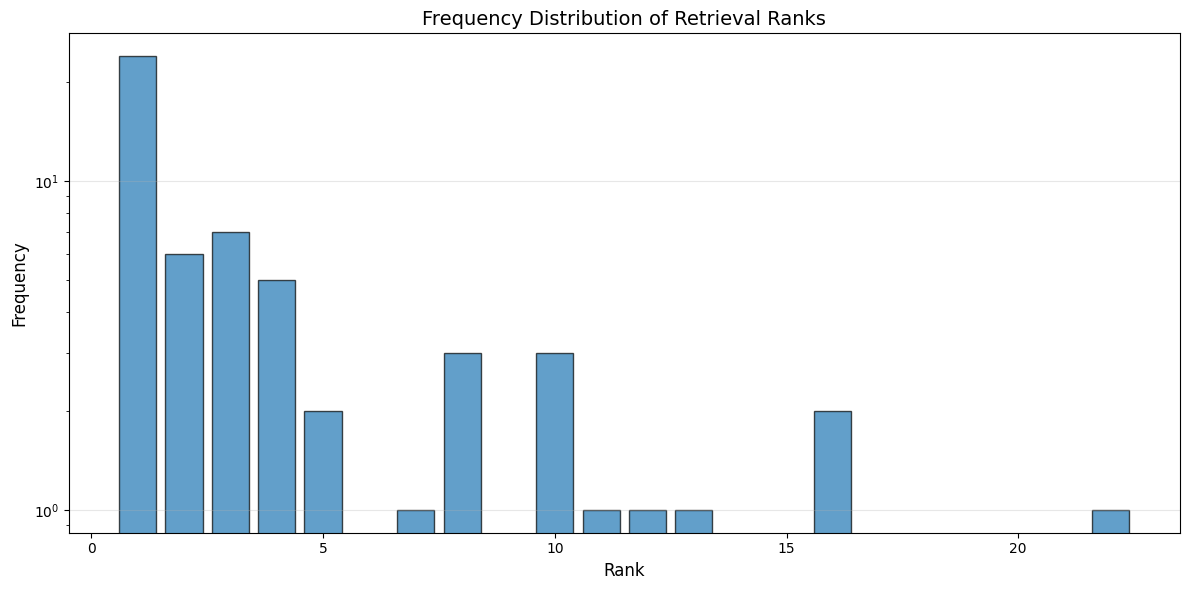

Rank range: 1 to 22
Most common ranks: [(nan, 40), (1, 24), (3, 7), (2, 6), (4, 5), (10, 3), (8, 3), (5, 2), (16, 2), (7, 1)]


In [21]:
from collections import Counter

import matplotlib.pyplot as plt

# Count frequency of each rank
rank_counts = Counter(val_metrics['ranks'])

# Sort by rank
sorted_ranks = sorted(rank_counts.keys())
frequencies = [rank_counts[r] for r in sorted_ranks]

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_ranks, frequencies, edgecolor='black', alpha=0.7)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Retrieval Ranks', fontsize=14)
plt.yscale('log')  # log scale to see smaller frequencies
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Rank range: {min(sorted_ranks)} to {max(sorted_ranks)}")
print(f"Most common ranks: {rank_counts.most_common(10)}")

## Summary: Knowledge Distillation Results

**Key Takeaways:**

1. **Distillation Concept**: By training the student model to mimic the frozen teacher (multimodal) model, we transfer knowledge from the teacher's multimodal understanding to the student's text-only architecture.

2. **Alignment Metrics**: The student successfully learns to align its vector space with the teacher's, as evidenced by:
   - MSE between student and teacher outputs
   - High cosine similarity (ideally > 0.9)
   - Similar t-SNE visualizations

3. **Retrieval Performance**: The distilled student should outperform the vanilla student (trained on GloVe) because it benefits from the teacher's learned multimodal representations without needing images at inference.

4. **Practical Benefit**: The distilled student can now:
   - Accept only text definitions at inference time
   - Produce embeddings compatible with teacher's multimodal understanding
   - Achieve better retrieval without access to images

This is a powerful technique for compressing knowledge from complex multimodal models into simpler, faster text-only models!
